<a href="https://colab.research.google.com/github/Puci123/Generative-Networks/blob/main/main12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 26421880/26421880 [00:01<00:00, 13947491.41it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266524.75it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4961793.37it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4184549.80it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

	Epoch 1 	Average Loss:  276.826274030937
	Epoch 2 	Average Loss:  262.70839429648373
	Epoch 3 	Average Loss:  259.8101731727358
	Epoch 4 	Average Loss:  258.1915508921119
	Epoch 5 	Average Loss:  257.2343890207638
	Epoch 6 	Average Loss:  256.188628312813
	Epoch 7 	Average Loss:  255.51615713689483
	Epoch 8 	Average Loss:  254.9420324564378
	Epoch 9 	Average Loss:  254.43134022198456
	Epoch 10 	Average Loss:  253.93659892137939
	Epoch 11 	Average Loss:  253.62695886373123
	Epoch 12 	Average Loss:  253.2488003769303
	Epoch 13 	Average Loss:  252.9759142842237
	Epoch 14 	Average Loss:  252.40013574055718
	Epoch 15 	Average Loss:  252.40197461263566
	Epoch 16 	Average Loss:  252.0583687656511
	Epoch 17 	Average Loss:  251.94335428839733
	Epoch 18 	Average Loss:  251.56564743322204
	Epoch 19 	Average Loss:  251.289335709255
	Epoch 20 	Average Loss:  251.2348745956803
	Epoch 21 	Average Loss:  251.0167

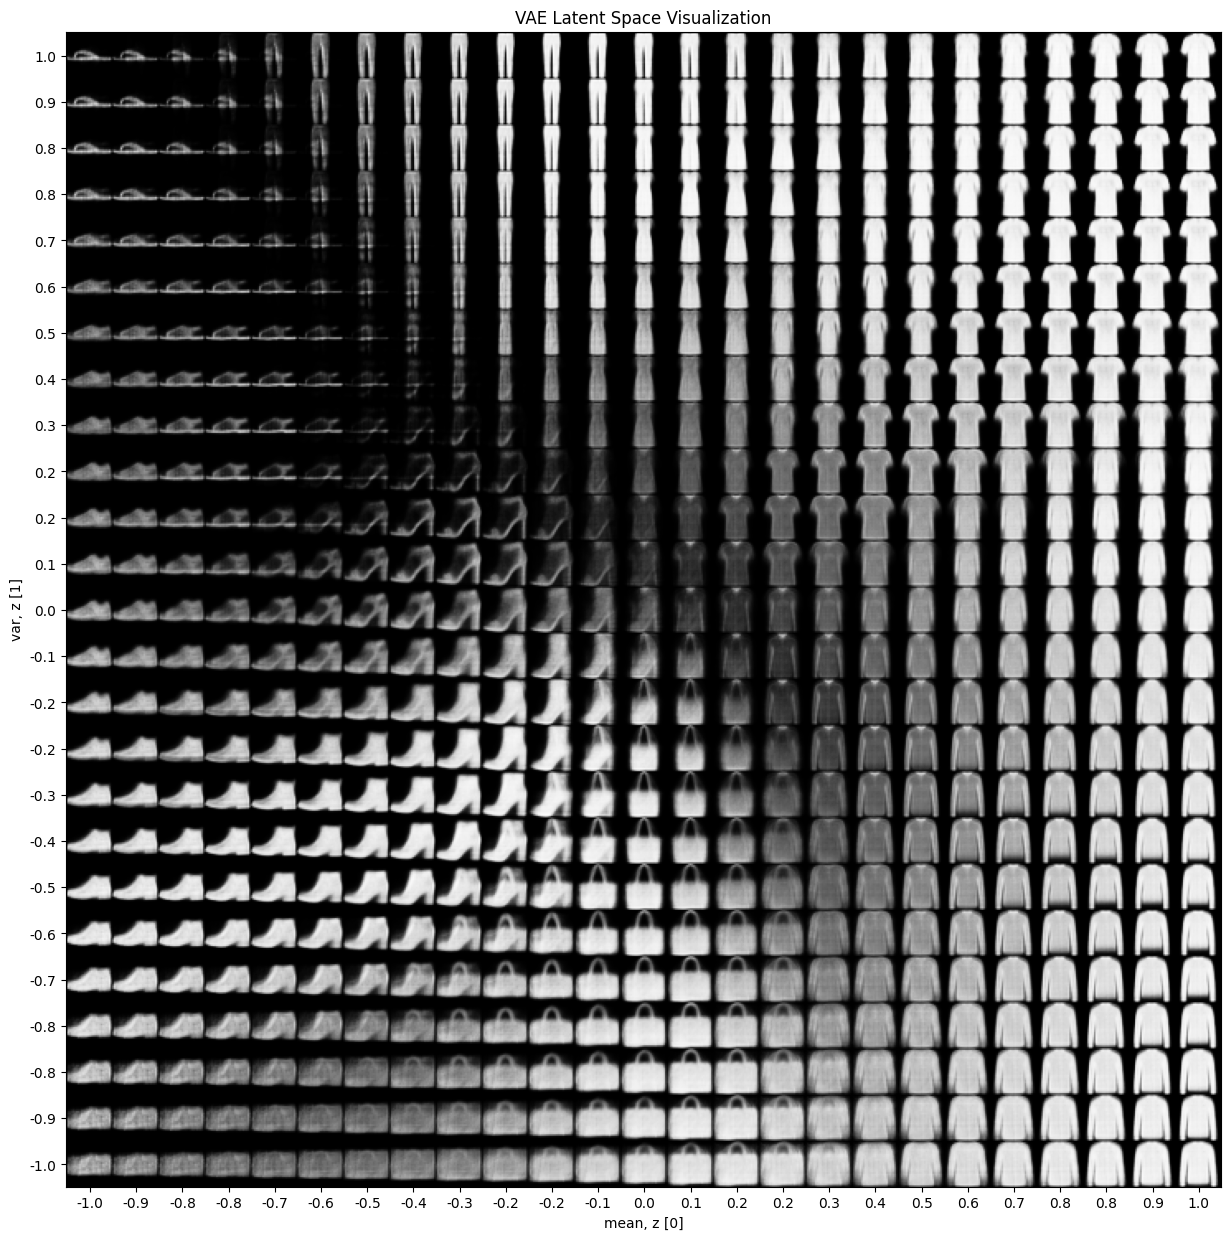

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import torchvision
from torch.optim import Adam
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def display_random_images(n=9, rows=3, columns=3):
    plt.style.use('grayscale')
    fig = plt.figure(figsize=(10, 7))
    images = []

    for i in range(n):
        id = random.randint(0, len(train_dataset))
        images.append(torch.Tensor.numpy(train_dataset[id][0][0]))
        fig.add_subplot(rows, columns, i + 1)
        plt.axis('off')
        plt.title(id)
        plt.imshow(images[i])

    # display some images
    # plt.show()

# display_random_images(12, 4, 3)


class Encoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var


class Decoder(nn.Module):

    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))

        x_hat = torch.sigmoid(self.output(x))
        return x_hat


class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=400, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var


model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)


def loss_function(x, x_hat, mean, log_var):
    x_normalized = (x - x.min()) / (x.max() - x.min())

    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x_normalized, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(-1, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    return overall_loss


train(model, optimizer, epochs=50, device=device)


def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()


def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size, ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model, scale=1.0)

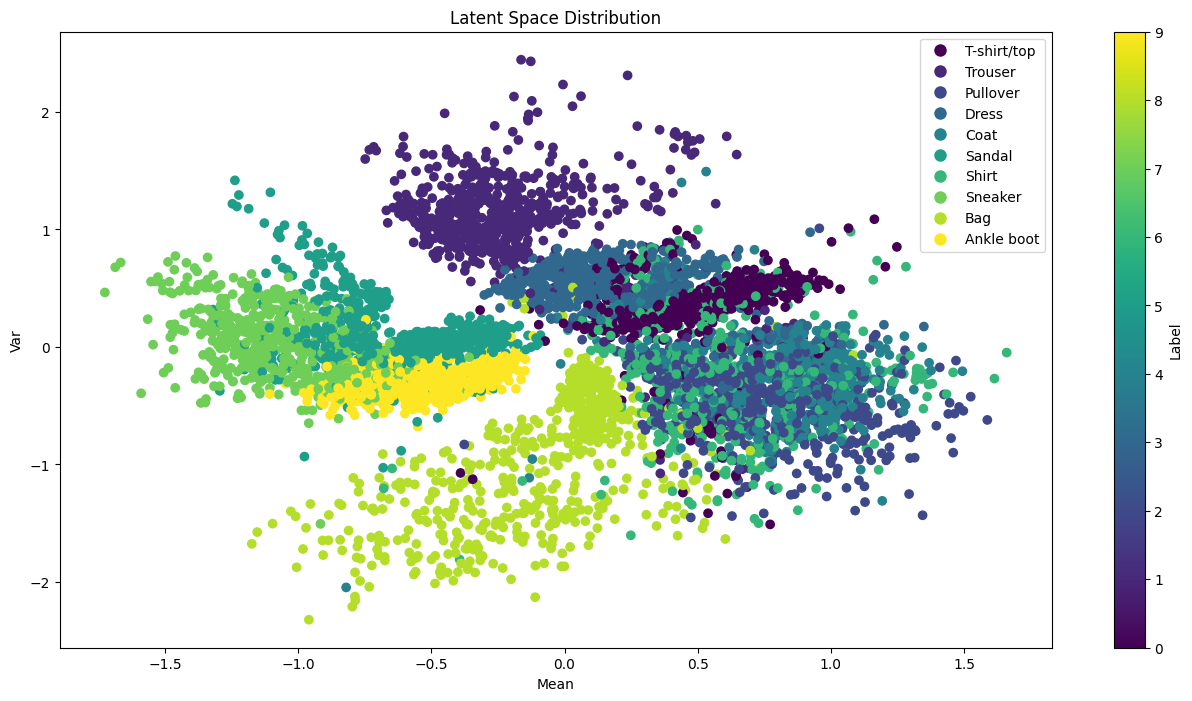

<Figure size 1600x800 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_latent_distribution(model, data_loader, num_batches=60, num_samples_per_class=30):
    model.eval()

    latent_points = []
    labels = []

    label_to_class = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
    }

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.view(-1, 784).to(device)
            mean, log_var = model.encode(x)
            z = model.reparameterization(mean, log_var)

            latent_points.append(z.cpu().numpy())
            labels.append(y.numpy())

            if batch_idx == num_batches - 1:
                break

    latent_points = np.concatenate(latent_points, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(16, 8))

    scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='viridis', label='Categories', alpha=1.0)
    plt.colorbar(scatter, label='Label')

    classes = np.unique(labels)
    legend_labels = [label_to_class[c] for c in classes]

    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10) for label in unique_labels]
    plt.legend(handles, legend_labels, loc='upper right')

    plt.title('Latent Space Distribution')
    plt.xlabel('Mean')
    plt.ylabel('Var')

    plt.figure(figsize=(16, 8))

    plt.show()

plot_latent_distribution(model, train_loader)

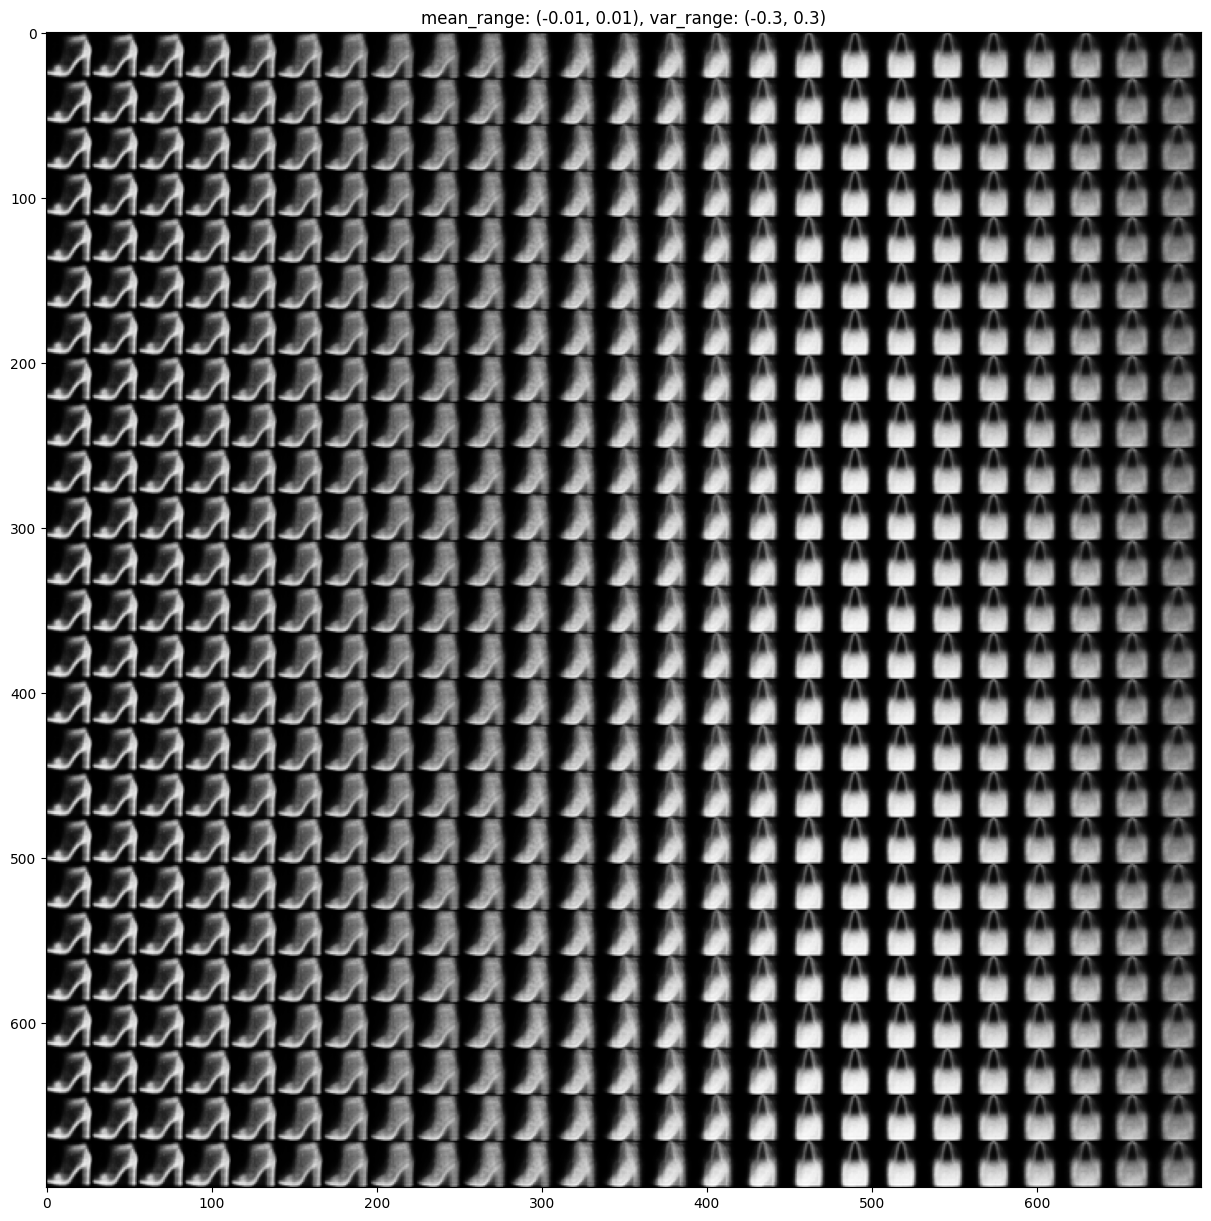

In [ ]:
def plot_const_mean_var_range(model, mean_range, var_range, scale=5.0, n=25, img_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((img_size * n, img_size * n))

    for i, mean in enumerate(np.linspace(mean_range[0], mean_range[1], n)):
        for j, var in enumerate(np.linspace(var_range[0], var_range[1], n)):
            z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(img_size, img_size)
            figure[i * img_size: (i + 1) * img_size, j * img_size: (j + 1) * img_size, ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title(f'mean_range: {mean_range}, var_range: {var_range}')
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Przykład użycia
plot_const_mean_var_range(model, mean_range=(-0.01, 0.01), var_range=(-0.3, 0.3), scale=5)